## 1. Creating EnergyPLAN data files according to scenarios 

### 1.1. Intro and reference file

This notebook provides the python code to automize running a series of scenarios on the EnergyPLAN model[^1], developed and maintained by Sustainable Energy Planning Research Group at Aalborg University, within Microsoft Windows OS. Turkey is the example case.

We use a framework file for scenarios, which is Turkey's 2020 reference data. 

Most of the data gathered from Energy Balance Sheet of EUROSTAT, with distribution files from EnergyPLAN's 2012-2020 Turkey reference file with the exception of electricity demand distribution which is updated according to Turkey's 2021 hourly distribution. Both the data and the distriburtion files are provided in the github page with relevant folder names.

[^1]: https://www.energyplan.eu/

In [1]:
import pandas

In [2]:
df_reference = pandas.read_csv(".../turkey_2020_ref.txt", encoding="utf16", header=None) #path to ref file
df_reference.head(10)

,0
0,EnergyPLAN version
1,16.0
2,EnergyUnit=
3,TWh/year
4,CapacityUnit=
5,MW
6,MonetaryUnit=
7,EUR
8,Input_el_demand_Twh=
9,306


### 1.2. Scenario bundle

This scenario bundle focuses on 52 variables that fall into four main categories/groups:
 * d_1 : total demand, household energy demand variables
 * d_2 : industry and other fuel consumption variables
 * d_3 : transportation fuel demand variables
 * s_p : energy supply capacity and fuel usage variables
 
It is assumed that these four groups can be altered with independent policies i.e. one group might be altered to a great extent
while the rest stay as they are. Therefore we define another three scenario groups which can affect these variables:
 * s_a, s_b, s_c which all foresees a change in the values of variables according to a method (which in detail is not relevant for this notebook).

Within `df_codes` dataframe name column is the EnergyPLAN txt input names of variables.

In [3]:
df_codes=pandas.read_csv(".../energyplan_main_sheet_codes.csv", encoding="latin5", index_col=0) # path to scenario file

In [4]:
df_codes.head(10)

,code,name,desc1,s_a,s_b,s_c
category,,,,,,
d_1,0,Input_el_demand_Twh=,electricity demand,428.8124575,413.3156875,416.45973
d_1,1,input_fuel_Households[1]=,coal boiler,13.98598596,8.7393,8.18792
d_1,1,input_fuel_Households[2]=,oil boiler,6.033858623,1.0924125,1.02349
d_1,1,input_fuel_Households[3]=,ngas boiler,170.2035058,174.786,163.7584
d_1,1,input_fuel_Households[4]=,biomass boiler,20.99554077,10.924125,10.2349
d_1,1,input_HH_ngasboiler_Solar=,solar thermal households,7.2636088,19.663425,18.42282
d_1,1,input_HH_EB_heat=,electric heating,4.195328447,12.7620625,11.25839
d_1,1,Input_Cooling_el_demand=,household cooling demand,6.992214078,13.92225,12.28188
d_2,2,input_fuel_CSHP[1]=,industry_coal,106.9802305,82.099,68.9875


As the categories/groups can alter independently, (say d_1 has the values of s_a, d_2 has the values of s_b and d_3 and s_p have the values of s_c scenarios) we define a combination of variable categories and scenarios with the following script: 

p.s. code credit for list combination: https://www.geeksforgeeks.org/python-program-to-get-all-unique-combinations-of-two-lists/#:~:text=The%20unique%20combination%20of%20two,elements%20of%20the%20second%20list.&text=Method%201%20%3A%20Using%20permutation(),and%20initialize%20list_1%20and%20list_2.

In [5]:
from itertools import product
 
categories = ["d_1","d_2","d_3","s_p"]
scenarios = ["s_a","s_b","s_c"]

cat_scen_combinations = []

cat_scen_combinations = list(list(zip(categories, element))
                             for element in product(scenarios, repeat = len(categories)))

scenario_list=[sum(m,()) for m in cat_scen_combinations]

In [6]:
scenario_list[:10]

[('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_a', 's_p', 's_a'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_a', 's_p', 's_b'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_a', 's_p', 's_c'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_b', 's_p', 's_a'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_b', 's_p', 's_b'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_b', 's_p', 's_c'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_c', 's_p', 's_a'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_c', 's_p', 's_b'),
 ('d_1', 's_a', 'd_2', 's_a', 'd_3', 's_c', 's_p', 's_c'),
 ('d_1', 's_a', 'd_2', 's_b', 'd_3', 's_a', 's_p', 's_a')]

For every scenario bundle, we have 4 pairs with 3 possibilities for each. In total we have 3^4=81 different combinations.

In [7]:
len(scenario_list)

81

For every combination we create scenario input txt files, imposing values from df_codes to df_reference for the related variables. Then save these scenario txt files to the Data folder of EnergyPlan. 

Name of every scenario txt file is the combination of variables as in the scenario_list like; d_1-s_a-d_2-s_b-d_3-s_c-s_p-s_a.txt

In [8]:
from copy import deepcopy

df_synth = deepcopy(df_reference)
noms = []

for scenario in scenario_list:
    #d_1 section
    sect_d1 = df_codes.loc[scenario[0], ["name", scenario[1]]]
    itemDict1 = {item[0]: item[1] for item in sect_d1.values.tolist()}
    for key,values in itemDict1.items():
        df_synth.loc[df_synth.loc[(df_synth[0] == key)].index[0]+1] = values
    #d_2 section
    sect_d2 = df_codes.loc[scenario[2], ["name", scenario[3]]]
    itemDict2 = {item[0]: item[1] for item in sect_d2.values.tolist()}
    for key,values in itemDict2.items():
        df_synth.loc[df_synth.loc[(df_synth[0] == key)].index[0]+1] = values
    #d_3 section
    y = df_codes.loc[scenario[4], ["name", scenario[5]]]
    itemDict3 = {item[0]: item[1] for item in y.values.tolist()}
    for key,values in itemDict3.items():
        df_synth.loc[df_synth.loc[(df_synth[0] == key)].index[0]+1] = values
    #s_p section
    u = df_codes.loc[scenario[6], ["name", scenario[7]]]
    itemDict4 = {item[0]: item[1] for item in u.values.tolist()}
    for key,values in itemDict4.items():
        df_synth.loc[df_synth.loc[(df_synth[0] == key)].index[0]+1] = values
    nom = "-".join(scenario) + ".txt"
    noms.append(nom)
    df_synth.to_csv(".../EnergyPLAN162/energyPlan Data/Data" + "/" + nom, index=False, header=False) #path to EnergyPLAN Data file

 Name of files created in scenarios folder

In [9]:
noms[:10]

['d_1-s_a-d_2-s_a-d_3-s_a-s_p-s_a.txt',
 'd_1-s_a-d_2-s_a-d_3-s_a-s_p-s_b.txt',
 'd_1-s_a-d_2-s_a-d_3-s_a-s_p-s_c.txt',
 'd_1-s_a-d_2-s_a-d_3-s_b-s_p-s_a.txt',
 'd_1-s_a-d_2-s_a-d_3-s_b-s_p-s_b.txt',
 'd_1-s_a-d_2-s_a-d_3-s_b-s_p-s_c.txt',
 'd_1-s_a-d_2-s_a-d_3-s_c-s_p-s_a.txt',
 'd_1-s_a-d_2-s_a-d_3-s_c-s_p-s_b.txt',
 'd_1-s_a-d_2-s_a-d_3-s_c-s_p-s_c.txt',
 'd_1-s_a-d_2-s_b-d_3-s_a-s_p-s_a.txt']

## 2. Automation Essentials

In order to

1. open the prepared input data in EnergyPLAN, 
2. run the scenario and copy the results in clipboard 
3. paste the clipboard to an excel file,

we need to define the mouse coordinates. Before running the code below, open EnergyPLAN without altering the window size,location etc.

Then run the code. While the code is running, click on the "open" file in program, then press the open file button within "open" window, with the scenario opened finally click on clipboard button again to get the relevant coordinates.

With every mouse click a mouse coordinate will be printed here as an output. You might want to try this process to guarantee
the correct coordinates before looping your scenarios. Clicking right mouse button stops the running code.

**Important note**: screen size changes coordinates, so if you are changing screens in between (like plugging your laptop to an external monitor) you need to repeat the coordinate hunt.

In [10]:
from pynput import * 

def get_coordinates(x,y, button, pressed):
    if button == mouse.Button.left:
        print("Now at: {}".format((x,y)))
    elif button == mouse.Button.right:
        return listen.stop()

def on_click(x, y, button, pressed):
    print('{0} at {1}'.format(
        'Pressed' if pressed else 'Released',
        (x, y)))
    
with mouse.Listener(on_click=get_coordinates) as listen:
    listen.join()
    

Now at: (134, 249)
Now at: (134, 249)
Now at: (345, 268)
Now at: (345, 268)
Now at: (132, 253)
Now at: (132, 253)
Now at: (2319, 1357)
Now at: (2319, 1357)


## 3. Running scenarios

Code below is a process which follows:

    1. Run the EnergyPLAN.exe
    2. Click open file in EnergyPLAN (mouse coordinate provided as "coords" should be changed)
    3. Send scenario name, looped as scenario
    4. Click open in open file window (mouse coordinate provided as "coords" should be changed)
    5. After scenario loaded in EnergyPLAN, click run clipboard (mouse coordinate provided as "coords" should be changed)
    6. Close EnergyPLAN by sending alt+f4 keys
    7. Open the Excel file (which needs to be created initially as an empty file previosly in a directory)
    8. Paste the clipboard by sending ctrl+v keys
    9. Open a new sheet by sending shift+f11 keys (for the following loops)
    10. Save excel by sending ctrl+s keys
    11. Close excel by sending alt+f4 keys
    12. next scenario back to step 1.

Eventually we end up with an excel file with 82 sheets. Last sheet created should be empty.

I throw some waiting seconds in between the steps in order to make sure the file is loaded, program is opened successfully etc. which should be adjusted to users' computers. 26 seconds of waiting in total for each scenario is to be on the safe side. It can be shorten by trial and error. 81 scenarios loop should finish in around 33 minutes with given wait times.

**Important note**: EnergyPLAN window should open in front of this notebook when we run the script below, in order to be interactible. If not, clickings will happen on this page, thus without any consequence (or some adverse consequences like alt+f4 if you don't interrupt it down the line). For me it generally does open in front but sometimes before running the loop I need to open the energyplan first manually and then close or minimize the notebook window then maximize and run again to make it work. I tried to embed `pywinauto.keyboard.send_keys("{VK_LWIN down}m{VK_LWIN up}")` before the for loop to get rid of this inconvenience, but couldn't make it reliably work. Once the initialization is correct, it shouldn't be a problem for the rest of the loop. 

In [26]:
import subprocess
import pywinauto
import time

for scenario in noms:    
    
    filepath = '.../EnergyPLAN162/energyPLAN.exe' #path to EnergyPLAN.exe file

    from pywinauto.application import Application
    # 1. Run the EnergyPLAN.exe
    app = Application(backend="uia").start(filepath) 
    
    time.sleep(3)
    # 2. Click open file in EnergyPLAN (mouse coordinate provided as "coords" should be changed)
    pywinauto.mouse.click(button='left', coords=(134, 249)) 
    
    time.sleep(1)
    # 3. Send scenario name, looped as scenario
    pywinauto.keyboard.send_keys(scenario) 

    time.sleep(2)
    # 4. Click open in open file window (mouse coordinate provided as "coords" should be changed)
    pywinauto.mouse.click(button='left', coords=(2319, 1357)) # click open in open window

    time.sleep(4)
    # 5. After scenario loaded in EnergyPLAN, click run clipboard (mouse coordinate provided as "coords" should be changed)
    pywinauto.mouse.click(button='left', coords=(345, 268)) # click clipboard

    time.sleep(3)
    # 6. Close EnergyPLAN by sending alt+f4 keys
    pywinauto.keyboard.send_keys("%{F4}")

    time.sleep(2)
    # 7. Open the Excel file (which needs to be created beforehand as an empty file in a directory of your choice)
    program_path = r"...Microsoft Office\root\Office16\EXCEL.exe" # path to EXCEL.exe file
    file_path    = r"...\results.xlsx" # path to previously opened results.xlsx file
    app2 = Application().start(r'{} "{}"'.format(program_path, file_path))

    time.sleep(5)
    # 8. Paste the clipboard by sending ctrl+v keys
    pywinauto.keyboard.send_keys('^v')

    time.sleep(2)
    # 9. Open a new sheet by sending shift+f11 keys (for the following loops)
    pywinauto.keyboard.send_keys('+{F11}')

    time.sleep(2)
    # 10. Save excel by sending ctrl+s keys
    pywinauto.keyboard.send_keys("^s")

    time.sleep(2)
    # 11. Close excel by sending alt+f4 keys
    pywinauto.keyboard.send_keys("%{F4}")

## 4. Using the "results" file

Results can be used in many different ways, following code is just to give an example. Data is to be arranged and plotted.

In [18]:
scenario_excel=pandas.ExcelFile(".../results.xlsx") #path to results.xlsx file

In [19]:
scenario_excel.sheet_names[:10]

['Sheet82',
 'Sheet81',
 'Sheet80',
 'Sheet79',
 'Sheet78',
 'Sheet77',
 'Sheet76',
 'Sheet75',
 'Sheet74',
 'Sheet73']

`noms` list was created in the firs section of this notebook. We will use it to name the results.

In [26]:
# omitting the ".txt"
name_list=[m[:-4] for m in noms] 
name_list.reverse()

In [27]:
name_list[:10]

['d_1-s_c-d_2-s_c-d_3-s_c-s_p-s_c',
 'd_1-s_c-d_2-s_c-d_3-s_c-s_p-s_b',
 'd_1-s_c-d_2-s_c-d_3-s_c-s_p-s_a',
 'd_1-s_c-d_2-s_c-d_3-s_b-s_p-s_c',
 'd_1-s_c-d_2-s_c-d_3-s_b-s_p-s_b',
 'd_1-s_c-d_2-s_c-d_3-s_b-s_p-s_a',
 'd_1-s_c-d_2-s_c-d_3-s_a-s_p-s_c',
 'd_1-s_c-d_2-s_c-d_3-s_a-s_p-s_b',
 'd_1-s_c-d_2-s_c-d_3-s_a-s_p-s_a',
 'd_1-s_c-d_2-s_b-d_3-s_c-s_p-s_c']

As every run clipboard command create the same result file in EnergyPLAN, locating the values we are interested once is enough. With a basic for loop reading and wiriting them in a seperate framework gives us the arranged results of each scenario.  

In [22]:
df3=pandas.DataFrame()

df3.index=["warning","co2_emissions","res_percent","res_production","generation_dist",
           "fuel_costs","var_costs","fixed_op_cost","annual_inv_cost","fuel_cons(twh)_total",
           "coal_cons(twh)","oil_cons(twh)","ngas_cons(twh)","biomass_cons(twh)","nuclear_cons(twh)","waste_cons(twh)",
           "tot_inv_cost"]
# electricity generation source distribution as a list in a cell
sources=["total", "wind","pv","river","hydro","cshp","pp1","pp2","geotherm"]

# we start the loop from the second sheet (sheet 81-index 1) in order to disregard empty sheet82
for sheet in scenario_excel.sheet_names[1:]:
    df2 = pandas.read_excel(".../results.xlsx", sheet_name=sheet) #path to results.xlsx file
    
    source_dist = [[m,n] for m,n in zip(sources,df2.iloc[83,[1,5,6,7,15,56,58,59,61]].tolist())]
    
    df3[sheet] = [df2.iloc[0,0],df2.iloc[15,1],df2.iloc[20,1],df2.iloc[21,1],
                  source_dist, df2.iloc[38,2],df2.iloc[60,1], df2.iloc[62,1],df2.iloc[64,1],df2.iloc[26,1],
                  df2.iloc[29,1],df2.iloc[30,1],df2.iloc[31,1],df2.iloc[32,1],df2.iloc[33,1],df2.iloc[34,1],
                  df2.iloc[6:61,7].sum()]

df3.columns = name_list

# scenario names in index, variables in columns
df4 = df3.transpose()

In [23]:
df4.head(5)

,warning,co2_emissions,res_percent,res_production,generation_dist,fuel_costs,var_costs,fixed_op_cost,annual_inv_cost,fuel_cons(twh)_total,coal_cons(twh),oil_cons(twh),ngas_cons(twh),biomass_cons(twh),nuclear_cons(twh),waste_cons(twh),tot_inv_cost
d_1-s_c-d_2-s_c-d_3-s_c-s_p-s_c,NaN,297.068,64.1,288.05,"[[total, 416.58], [wind, 66.25], [pv, 51.46], ...",31569,60295,10898,25179,1360.34,144.33,449.4,624.8,82.1,59.71,1,501828
d_1-s_c-d_2-s_c-d_3-s_c-s_p-s_b,NaN,305.952,63.8,286.64,"[[total, 416.58], [wind, 67.2], [pv, 40.55], [...",31797,61930,10707,24464,1386.15,149.67,451.17,657.07,88.44,39.81,1,476241
d_1-s_c-d_2-s_c-d_3-s_c-s_p-s_a,NaN,336.068,50.7,227.53,"[[total, 416.58], [wind, 48.48], [pv, 19.79], ...",32317,66445,11000,24329,1504.29,182.12,455.13,745.07,82.16,39.81,0.2,484302
d_1-s_c-d_2-s_c-d_3-s_b-s_p-s_c,NaN,335.215,63.3,289.16,"[[total, 416.62], [wind, 66.45], [pv, 51.46], ...",38380,68684,10926,25203,1513.33,146.25,567.95,653,86.42,59.71,1,502191
d_1-s_c-d_2-s_c-d_3-s_b-s_p-s_b,NaN,344.23,63,287.72,"[[total, 416.62], [wind, 67.38], [pv, 40.55], ...",38613,70326,10735,24488,1539.66,151.85,569.72,685.47,92.82,39.81,1,476604


For a simple descriptive illustration of results, we look at the relations of CO2 emissions and fuel consumption(TWh) to other variables with s_p (electricity generation capacities) classes according to scenario matches (a,b and c).

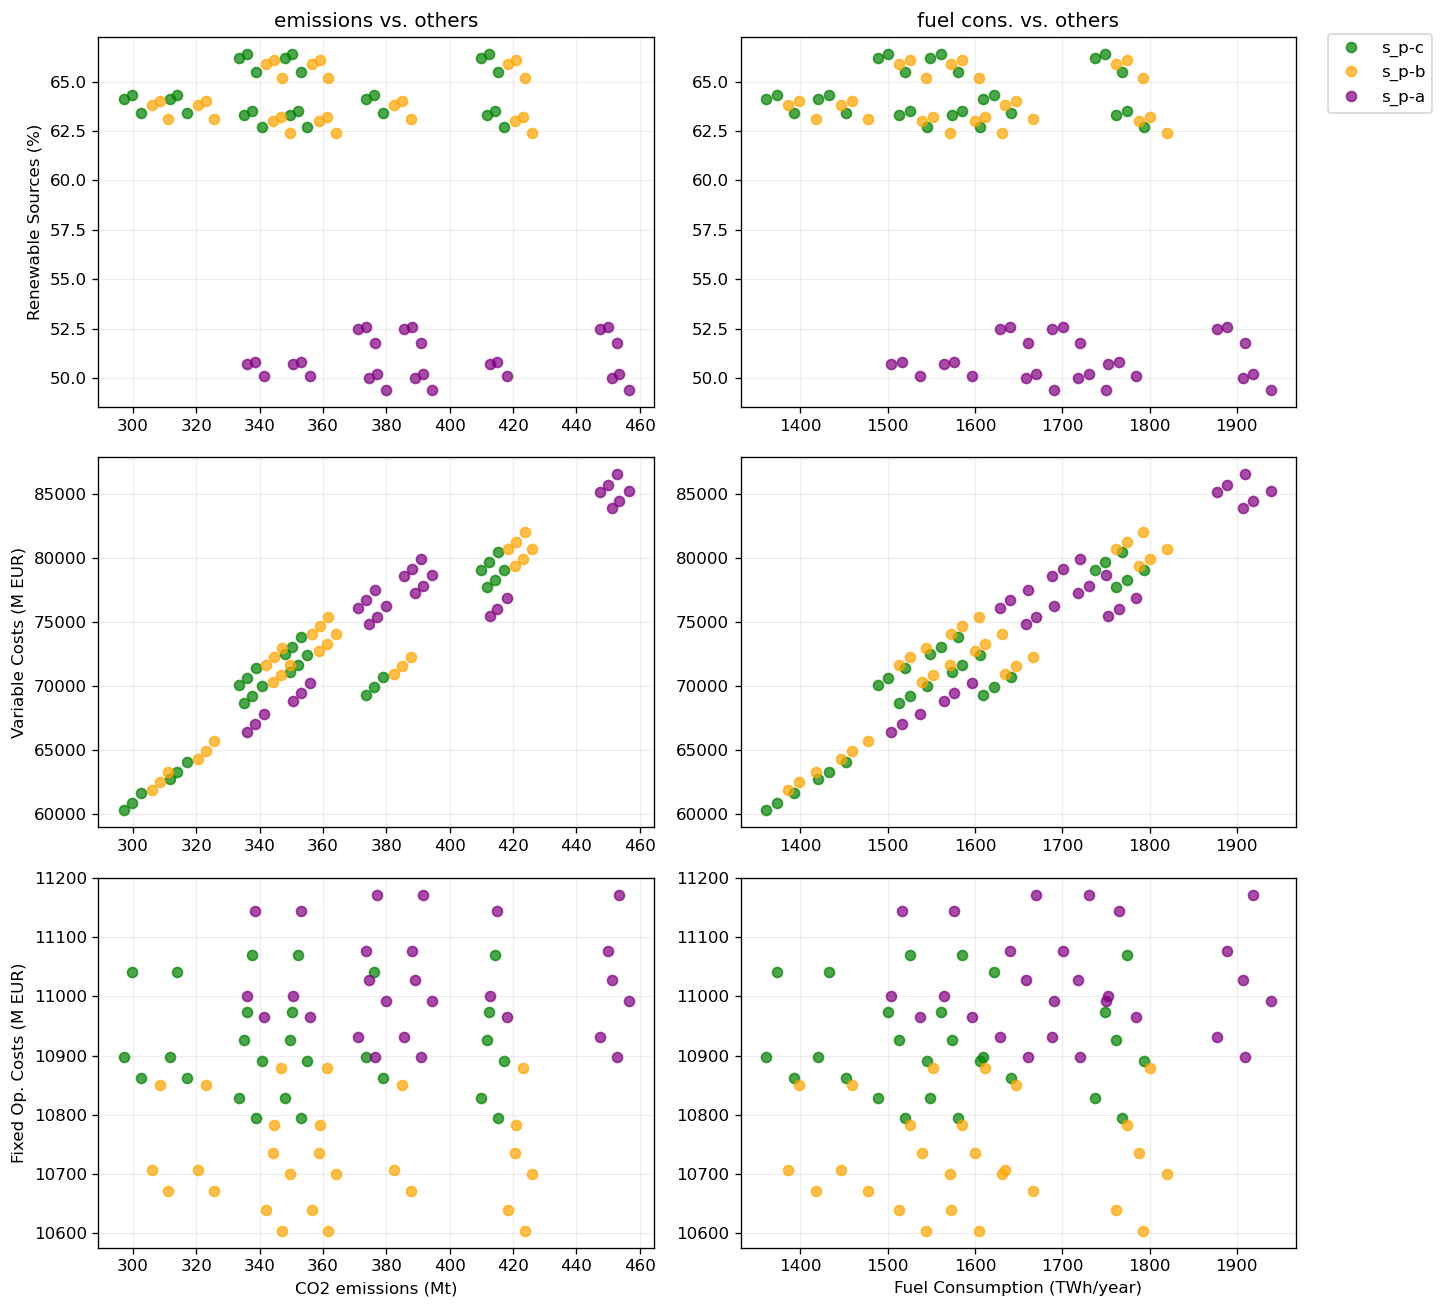

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2)

#s_p variables a,b and c scenarios
plot_class=[]
for m in df4.index.tolist():
    if m[-3:] == "s_c":
        plot_class.append("green")
    elif m[-3:] == "s_b":
        plot_class.append("orange")
    else:
        plot_class.append("purple")

df4["plot_class"] = plot_class

x_axs = ["co2_emissions", "fuel_cons(twh)_total"]
y_axs = ["res_percent", "var_costs", "fixed_op_cost"]

for ind_0, x_ax in enumerate(x_axs):
    for ind_1, y_ax in enumerate(y_axs):
        for color,l in zip(['green', 'orange', 'purple'],["s_p-c","s_p-b","s_p-a"]):
            x = df4[df4["plot_class"]==color][x_ax].values 
            y = df4[df4["plot_class"]==color][y_ax].values
            ax[ind_1, ind_0].plot(x, y, c=color, label=l, marker="o", alpha=0.7, linewidth=0, markeredgecolor=None)
            ax[ind_1, ind_0].grid(True, alpha = 0.2)

ax[0, 0].set_title("emissions vs. others")
ax[0, 0].set_ylabel("Renewable Sources (%)")
ax[1, 0].set_ylabel("Variable Costs (M EUR)")
ax[2, 0].set_ylabel("Fixed Op. Costs (M EUR)")
ax[2, 0].set_xlabel("CO2 emissions (Mt)")
ax[0, 1].set_title("fuel cons. vs. others")
ax[2, 1].set_xlabel("Fuel Consumption (TWh/year)")

fig.legend(labels=["s_p-c","s_p-b","s_p-a"], loc='center', bbox_to_anchor=(1.05, 0.94))

fig.set_dpi(120)
fig.set_size_inches(11, 11)
plt.tight_layout()
plt.show()